In [1]:
import tensorflow as tf
import kerastuner as kt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow import feature_column
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import DenseFeatures, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
seed = 3
assert(tf.__version__ > '2.1.0')

In [3]:
# Read in training data
path = 'data/input/collated/train.csv'
train = pd.read_csv(path, sep=',')

# Read in test data
path = 'data/input/collated/test.csv'
test = pd.read_csv(path, sep=',')

In [4]:
tcr = train.drop(['epitope', 'y'], axis=1)
tcr.drop_duplicates(inplace=True)

train_tcrs, val_tcrs = train_test_split(tcr, test_size=0.10, random_state=seed)

val = pd.merge(val_tcrs, train, how='inner')
train = pd.merge(train_tcrs, train, how='inner')

In [5]:
# Create a tensorflow dataset from a pandas dataframe
def df_to_ds(df, shuffle=True, batch_size=32):
    
    df = df.copy()
    labels = df.pop('y')
    
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))  
    
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    
    ds = ds.batch(batch_size)
    
    return(ds)

In [6]:
batch_size = 96

train_ds = df_to_ds(train, batch_size=batch_size)
val_ds = df_to_ds(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_ds(test, shuffle=False, batch_size=batch_size)

In [7]:
def model_builder(hp):
    model = Sequential()

    feature_columns = []
    vocab = {}

    # embeddings
    for header in train.columns.difference(['y']):
        vocab[header] = list(dict.fromkeys(list(train[header].unique())))
        fc = feature_column.categorical_column_with_vocabulary_list(header, vocab[header])
        d = hp.Int('dim_'+header, min_value=10, max_value=350, step=10)
        feature_columns.append(feature_column.embedding_column(fc, dimension=d))

        
    model.add(DenseFeatures(feature_columns))
    
    for i in range(hp.Int('n_layers', 0, 6)):
    
        model.add(Dense(units=hp.Int('units_'+str(i), min_value=64, max_value=512, step=32),
                    activation='relu'))
    
    model.add(Dense(units=1, activation='sigmoid'))


    #hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  
    model.compile(optimizer = Adam(),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                  metrics = ['accuracy', 'AUC'])  
    
    batch_size = hp.Int('batch_size', min_value=32, max_value=256, step=32)

    train_ds = df_to_ds(train, batch_size=batch_size)
    val_ds = df_to_ds(val, shuffle=False, batch_size=batch_size)
    test_ds = df_to_ds(test, shuffle=False, batch_size=batch_size)
  
    return model

In [8]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'hyperopt',
                     project_name = 'tcr') 

In [9]:
import IPython

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [10]:
tuner.search(train_ds,  
             epochs=10, 
             validation_data=val_ds, 
             verbose=2,
             callbacks=[ClearTrainingOutput()])


INFO:tensorflow:Oracle triggered exit


In [161]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the densely-connected layers are: 
layer1: {best_hps.get('units_1')}
layer2: {best_hps.get('units_2')}
layer3: {best_hps.get('units_3')}

The optimal dimensions of the embedding layers are: 
cdr3a: {best_hps.get('dim_cdr3a')}
cdr3b: {best_hps.get('dim_cdr3b')}
epitope: {best_hps.get('dim_epitope')}
hla: {best_hps.get('dim_hla')}
v_a: {best_hps.get('dim_v_a')}
j_a: {best_hps.get('dim_j_a')}
v_b: {best_hps.get('dim_v_b')}
j_b: {best_hps.get('dim_j_b')}

the optimal batch_size:
{best_hps.get('batch_size')}

the optimal n_layers:
{best_hps.get('n_layers')}
""")


The hyperparameter search is complete. 
The optimal number of units in the densely-connected layers are: 
layer1: 224
layer2: 96
layer3: 128

The optimal dimensions of the embedding layers are: 
cdr3a: 60
cdr3b: 30
epitope: 140
hla: 190
v_a: 50
j_a: 70
v_b: 100
j_b: 100

the optimal batch_size:
32

the optimal n_layers:
3



In [12]:
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    patience=2, 
    restore_best_weights=True
)

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
model.fit(train_ds, 
          validation_data=val_ds,
          epochs=10,
          callbacks=[early_stop],
          verbose=2)

Epoch 1/10
404/404 - 7s - loss: 0.1134 - accuracy: 0.9575 - auc: 0.9919 - val_loss: 0.0704 - val_accuracy: 0.9746 - val_auc: 0.9972
Epoch 2/10
404/404 - 6s - loss: 0.0464 - accuracy: 0.9828 - auc: 0.9984 - val_loss: 0.0787 - val_accuracy: 0.9736 - val_auc: 0.9962
Epoch 3/10
404/404 - 6s - loss: 0.0286 - accuracy: 0.9889 - auc: 0.9992 - val_loss: 0.0904 - val_accuracy: 0.9778 - val_auc: 0.9934
Epoch 4/10
404/404 - 7s - loss: 0.0178 - accuracy: 0.9931 - auc: 0.9996 - val_loss: 0.0791 - val_accuracy: 0.9799 - val_auc: 0.9934
Epoch 5/10
404/404 - 7s - loss: 0.0121 - accuracy: 0.9952 - auc: 0.9999 - val_loss: 0.1071 - val_accuracy: 0.9813 - val_auc: 0.9925
Epoch 6/10
404/404 - 6s - loss: 0.0096 - accuracy: 0.9964 - auc: 0.9998 - val_loss: 0.1345 - val_accuracy: 0.9792 - val_auc: 0.9900
Epoch 7/10
404/404 - 6s - loss: 0.0080 - accuracy: 0.9973 - auc: 0.9998 - val_loss: 0.1249 - val_accuracy: 0.9813 - val_auc: 0.9906


In [160]:
%%time

loss, accuracy, auc = model.evaluate(test_ds, verbose=2)
print("Accuracy", accuracy)
print("AUC", auc)

50/50 - 0s - loss: 0.0708 - accuracy: 0.9859 - auc: 0.9944
Accuracy 0.9858887791633606
AUC 0.9943863153457642
CPU times: user 254 ms, sys: 79.1 ms, total: 333 ms
Wall time: 125 ms


In [167]:
model.save('models/v_paper/')
model.summary()

INFO:tensorflow:Assets written to: models/v_paper/assets
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  1350040   
_________________________________________________________________
dense (Dense)                multiple                  142272    
_________________________________________________________________
dense_1 (Dense)              multiple                  43232     
_________________________________________________________________
dense_2 (Dense)              multiple                  21600     
_________________________________________________________________
dense_3 (Dense)              multiple                  97        
Total params: 1,557,241
Trainable params: 1,557,241
Non-trainable params: 0
_________________________________________________________________


In [176]:
tf.keras.utils.plot_model(
    model, to_file='paper/diagrams/model-plot1.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [15]:
predictions = model.predict(test_ds)

In [155]:
accu = pd.DataFrame(columns=['epitope', 'y', 'y_hat'])
accu['epitope'] = test['epitope']
accu['y'] = test['y']
accu['y_hat'] = (predictions>0.5)/1.
accu['match'] = 1-(accu['y'] - accu['y_hat'])**2

In [156]:
pd.set_option('display.max_rows', 220)

correct = accu.groupby(['epitope']).agg({'match': 'sum'})
total = accu.groupby(['epitope']).agg({'match': 'count'})
acc = correct.div(total, level='epitope').sort_values('match', ascending=False)
pd.merge(acc,total, how='inner', on='epitope', suffixes=['_ratio', '_examples'])

,match_ratio,match_examples
epitope,,
AAGIGILTV,1.000000,11
LYPEFIASI,1.000000,9
LPEPLGQGQLTAY,1.000000,12
LPEPLPQAQLTAY,1.000000,9
LPEPLPQGALTAY,1.000000,9
LPEPLPQGGLTAY,1.000000,7
LPEPLPQGQATAY,1.000000,13
LPEPLPQGQGTAY,1.000000,9
LPEPLPQGQLGAY,1.000000,12


In [157]:
acc[acc['match']==1].count()

match    167
dtype: int64

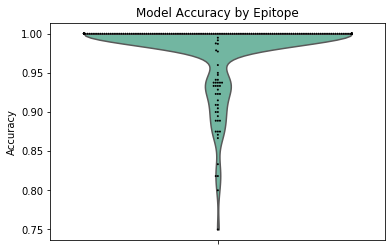

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.violinplot(y='match', data=acc, inner=None, cut=0, palette='Set2')
ax = sns.swarmplot(y='match', data=acc,
                   color='black', edgecolor='white', size=2)
ax.set(ylabel='Accuracy', 
       title='Model Accuracy by Epitope')

plt.savefig('paper/diagrams/accuracy-swarm.svg', format='svg', bbox_inches='tight')

In [136]:
preds = pd.DataFrame(columns=['epitope', 'y', 'y_hat'])
preds['epitope'] = test['epitope']
preds['y'] = test['y']
preds['y_hat'] = predictions

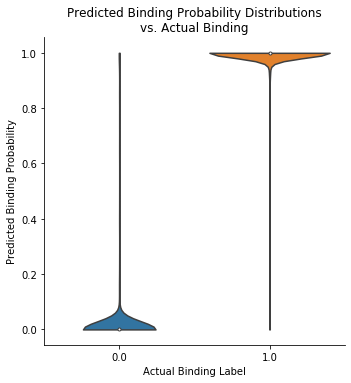

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.catplot(x='y', y='y_hat', data=preds, kind='violin', cut=0)
ax.set(xlabel='Actual Binding Label', 
       ylabel='Predicted Binding Probability', 
       title='Predicted Binding Probability Distributions\nvs. Actual Binding')

plt.savefig('paper/diagrams/accuracy-threshold.svg', format='svg', bbox_inches='tight')

In [138]:
hla = pd.DataFrame(columns=['hla', 'y', 'y_hat'])
hla['hla'] = test['hla']
hla['y'] = test['y']
hla['y_hat'] = (predictions>0.5)/1.
hla['match'] = 1-(hla['y'] - hla['y_hat'])**2

In [139]:
pd.set_option('display.max_rows', 220)

correct = hla.groupby(['hla']).agg({'match': 'sum'})
total = hla.groupby(['hla']).agg({'match': 'count'})
acc = correct.div(total, level='hla').sort_values('match', ascending=False)
total = train.groupby(['hla']).agg({'y': 'count'})
acc = pd.merge(acc,total, how='inner', on='hla', suffixes=['_ratio', '_examples'])

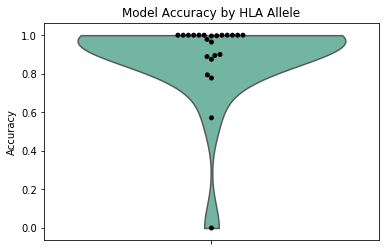

In [140]:
ax = sns.violinplot(y='match', data=acc, inner=None, cut=0, palette='Set2')
ax = sns.swarmplot(y='match', data=acc,
                   color='black', edgecolor='white', size=5)
ax.set(ylabel='Accuracy', title='Model Accuracy by HLA Allele')

plt.savefig('paper/diagrams/accuracy-swarm-hla.svg', format='svg', bbox_inches='tight')

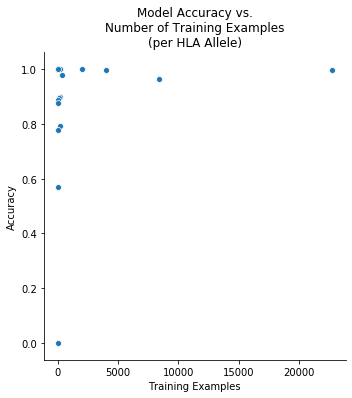

In [141]:
ax = sns.relplot(x='y', y='match', data=acc)
ax.set(xlabel='Training Examples', 
       ylabel='Accuracy', 
       title='Model Accuracy vs.\nNumber of Training Examples\n(per HLA Allele)')

plt.savefig('paper/diagrams/accuracy-hla-scatter.svg', format='svg', bbox_inches='tight')